In [1]:
import torch
from normalizing_flows.flows import Flow, PrincipalManifoldFlow
from normalizing_flows.bijections import RealNVP

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../')

from test.shapes import *

sys.path.remove('../')

Text(0.5, 1.0, 'Swirl')

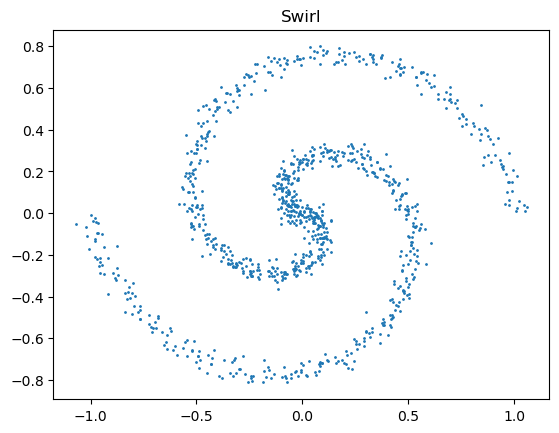

In [3]:
num_points = 1000
data_swirl = swirl(radius=1, angle=0, num_points=num_points, noise_std=0.03, seed=0)

# plot data
plt.figure()
plt.scatter(data_swirl[0], data_swirl[1], s=1)
plt.title('Swirl')

In [4]:
# prepare the data
data_tensor = torch.tensor(np.stack(data_swirl, axis=1)).float()  # Create a tensor from the data
n_dim = 2

In [5]:
# torch.manual_seed(0)
# normal_flow = Flow(RealNVP(n_dim, n_layers=10), record_Ihat_P=True, record_log_px=True)
# normal_flow.fit(data_tensor, show_progress=True)

In [6]:
# x = torch.tensor([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]).float()
# result = torch.vmap(normal_flow.bijection.forward, chunk_size=1)(x.unsqueeze(1))
# print(result)

In [7]:
# NF_log_px = normal_flow.get_log_px()
# NF_Ihat_P = normal_flow.get_Ihat_P()

# # print all
# print("NF_log_px: ", len(NF_log_px))
# print("NF log_px average: ", torch.mean(NF_log_px))
# print("NF_Ihat_P: ", len(NF_Ihat_P))
# print("NF Ihat_P average: ", torch.mean(NF_Ihat_P))

In [8]:
torch.manual_seed(0)
PM_flow = PrincipalManifoldFlow(RealNVP(n_dim, n_layers=10), record_Ihat_P=True, record_log_px=True, debug=False, objective="unbiased")
PM_flow.fit(data_tensor, show_progress=True)

Fitting Principal Manifold Flow: 100%|██████████| 500/500 [04:28<00:00,  1.86it/s, Training loss (batch): -inf]


In [9]:
from scipy.stats import norm

N = 201
u_range = v_range = torch.linspace(1e-3, 1.0 - 1e-3, N)
u_range = torch.tensor(norm.ppf(u_range.numpy()))
v_range = torch.tensor(norm.ppf(v_range.numpy()))
u, v = torch.meshgrid(u_range, v_range, indexing='ij')
uv = torch.stack([u, v], axis=-1)
horiz_lines = uv[::10]
vert_lines = uv[:, ::10].permute(1, 0, 2)  


In [12]:
print(horiz_lines.shape)

torch.Size([21, 201, 2])


torch.Size([21, 201, 2])
torch.Size([21, 201, 2])


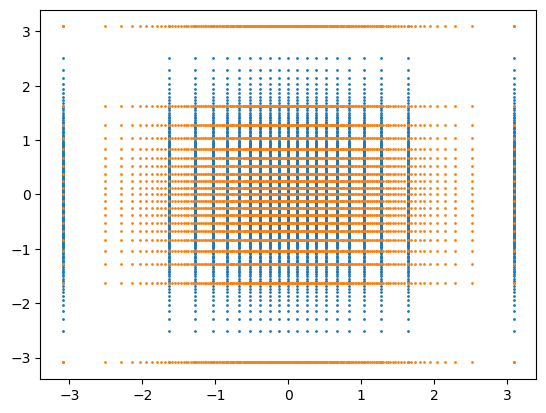

In [21]:
# plt.scatter(*horiz_lines.T, s=1.0)
# plt.scatter(*vert_lines.T, s=1.0)
# Check the shape of horiz_lines and vert_lines
print(horiz_lines.shape)
print(vert_lines.shape)

# Reshape or slice if necessary to get the right format (N, 2) for scatter
# If it's (N, 2), you're good to go, otherwise reshape as needed
horiz_lines_reshaped = horiz_lines.reshape(-1, 2).float()
vert_lines_reshaped = vert_lines.reshape(-1, 2).float()

# Now you can unpack these arrays correctly into scatter
plt.scatter(horiz_lines_reshaped[:, 0], horiz_lines_reshaped[:, 1], s=1.0)
plt.scatter(vert_lines_reshaped[:, 0], vert_lines_reshaped[:, 1], s=1.0)

plt.show()

In [22]:
# put all horizontal and vertical lines through the flow
horiz_lines_flow = PM_flow.bijection.forward(horiz_lines_reshaped)
vert_lines_flow = PM_flow.bijection.forward(vert_lines_reshaped)

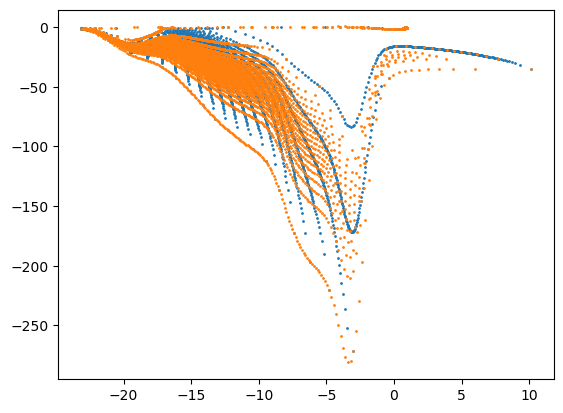

In [30]:
plt.scatter(horiz_lines_flow[0][:, 0].detach().numpy(), horiz_lines_flow[0][:, 1].detach().numpy(), s=1.0)
plt.scatter(vert_lines_flow[0][:, 0].detach().numpy(), vert_lines_flow[0][:, 1].detach().numpy(), s=1.0)
